In [1]:
import pandas as pd
path_to_data = "..//data//"

df = pd.read_csv(path_to_data+"pm_data.csv")
sensors_df = pd.read_csv(path_to_data+"sensors.csv")

In [2]:
nan_percentage = df.isnull().mean() * 100

threshold = 95  
filtered_df = df.loc[:, nan_percentage <= threshold]

In [3]:
filtered_sensors = filtered_df.columns[2:-1]
filtered_sensors_df = sensors_df.loc[sensors_df['id'].astype('str').isin(filtered_sensors)]

In [4]:
train_df = pd.read_csv(path_to_data+"raw_train.csv")

In [5]:
import folium

# Create a map centered around an average latitude and longitude
m = folium.Map(location=[filtered_sensors_df["lat"].mean(), filtered_sensors_df["lng"].mean()], zoom_start=2)

# Add sensor points to the map with labels above markers
for _, row in filtered_sensors_df.iterrows():
    # Add the marker
    folium.Marker(
        location=[row["lat"], row["lng"]],
        popup=f"Sensor ID: {row['id']}",
    ).add_to(m)
    
    # Add the label (CircleMarker with a tooltip for the text)
    folium.map.Marker(
        location=[row["lat"] + 0.005, row["lng"]],  # Slightly above the marker
        icon=folium.DivIcon(html=f"""
            <div style="font-size: 10px; color: black; text-align: center;">
                {row['id']}
            </div>
        """)
    ).add_to(m)

# Save or display the map
m.save("sensors_map_with_labels_filtered.html")  # Save as HTML

# checking close sensors

In [6]:
import plotly.graph_objects as go

def plot_pm(df, column):
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=df['full_date'],
            y=df[column],
            mode='lines+markers',
            name=column,
            connectgaps=False  # Ensures gaps for NaN values
        )
    )
    fig.update_layout(
        title=f"Values of {column} Over Time",
        xaxis_title="Date",
        yaxis_title="Value",
        legend_title="Feature"
    )
    fig.show()

## initial geographical clustering

In [7]:
import requests
import pandas as pd

# Function to get altitude from Open-Elevation API
def get_altitude(lat, lon):
    url = "https://api.open-elevation.com/api/v1/lookup"
    params = {"locations": f"{lat},{lon}"}
    response = requests.get(url, params=params)
    if response.status_code == 200:
        results = response.json().get("results", [])
        if results:
            return results[0].get("elevation", None)
    return None

In [ ]:
sensors_df["altitude"] = sensors_df.apply(lambda row: get_altitude(row["lat"], row["lng"]), axis=1)
sensors_df

In [ ]:
missing_altitudes = {
    9: 1095,
    10: 838,
    11: 988,
    12: 1357,
    15: 776,
    16: 631,
    4438736: 875,
    4439094: 1014,
    4439475: 764,
    37380840: 1192,
    38737023: 508,
}

In [ ]:
for id, alt in missing_altitudes.items():
    sensors_df.loc[sensors_df['id']==id, "altitude"] = alt

In [ ]:
import geopy.distance

tec_coords = [(43.28106778655262, 76.92824292448644), (43.29301578613313, 76.79849657217129), (43.4226463963046, 77.00610304272645)]

for i, tec_coord in enumerate(tec_coords, start=1):
    sensors_df[f"distance_to_point_{i}"] = sensors_df.apply(
        lambda row: geopy.distance.geodesic((row["lat"], row["lng"]), tec_coord).km,
        axis=1
    )

In [ ]:
import folium

# Create a map centered around an average latitude and longitude of the filtered sensors
m = folium.Map(location=[sensors_df["lat"].mean(), sensors_df["lng"].mean()], zoom_start=2)

# Add sensor points to the map with labels above markers
for _, row in sensors_df.iterrows():
    # Add the marker for the sensor
    folium.Marker(
        location=[row["lat"], row["lng"]],
        popup=f"Sensor ID: {row['id']}",
    ).add_to(m)
    
    # Add the label (using DivIcon for text)
    folium.map.Marker(
        location=[row["lat"] + 0.005, row["lng"]],  # Slightly above the marker
        icon=folium.DivIcon(html=f"""
            <div style="font-size: 10px; color: black; text-align: center;">
                {row['id']}
            </div>
        """)
    ).add_to(m)

# Add tec_coords to the map with red markers
for idx, coord in enumerate(tec_coords, start=1):
    folium.Marker(
        location=coord,
        popup=f"Tec Point {idx}",
        icon=folium.Icon(color="red", icon="info-sign")  # Red marker with "info-sign" icon
    ).add_to(m)

# Save or display the map
m.save("sensors_map_with_labels_and_tec_coords.html")  # Save as HTML

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class SeasonalStatisticsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def _determine_season(self, date):
        """Assign a season based on the month."""
        month = date.month
        if month in [11, 12, 1, 2]:  # seson otoplenia
            return "winter"
        elif month in [6, 7, 8]:  # ideal conditions = summer
            return "summer"
        else:
            return "other"

    def fit(self, X, y=None):
        """No fitting required for this transformer."""
        return self

    def transform(self, X, sensors_list):
        """Compute statistics for seasonal and overall time series data."""
        if 'full_date' not in X.columns:
            raise ValueError("Input DataFrame must contain a 'full_date' column with datetime values.")

        X = X.copy()
        
        # Ensure full_date is a datetime object
        X['full_date'] = pd.to_datetime(X['full_date'])
        
        # Add a season column
        X['season'] = X['full_date'].apply(self._determine_season)

        # Initialize a dictionary to store statistics
        stats = []

        # Process each feature
        for feature in sensors_list:
            if feature in ['full_date', 'season']:
                continue

            feature_data = X[feature].dropna()

            # Overall statistics
            overall_mean = feature_data.mean()
            overall_std = feature_data.std()

            # Winter and summer statistics
            winter_data = X.loc[X['season'] == 'winter', feature].dropna()
            summer_data = X.loc[X['season'] == 'summer', feature].dropna()

            mean_winter = winter_data.mean()
            std_winter = winter_data.std()
            mean_summer = summer_data.mean()
            std_summer = summer_data.std()

            # Additional statistics
            min_value = feature_data.min()
            max_value = feature_data.max()
            median_value = feature_data.median()

            # Append to stats list
            stats.append({
                "feature": feature,
                "mean": overall_mean,
                "std": overall_std,
                "mean_winter": mean_winter,
                "std_winter": std_winter,
                "mean_summer": mean_summer,
                "std_summer": std_summer,
                "min": min_value,
                "max": max_value,
                "median": median_value
            })

        # Convert statistics to a DataFrame
        stats_df = pd.DataFrame(stats).set_index('feature')

        return stats_df


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class GeoFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Selects geographical features (e.g., altitude, distance_from_power_station)
    for each sensor in the same order as the columns of time_series_df.
    """
    def __init__(self, geo_df, feature_cols=None):
        """
        geo_df: DataFrame with columns ['sensor_id', ... feature columns ...]
        feature_cols: list of str, which columns in geo_df to use
        """
        self.geo_df = geo_df.set_index('sensor_id')
        self.feature_cols = feature_cols if feature_cols else self.geo_df.columns.tolist()
        
    def fit(self, X, y=None):
        # Nothing to learn here
        return self
    
    def transform(self, X):
        """
        X: array-like of sensor IDs (or just a placeholder if we rely on the existing order)
        We assume X is a list or array of sensor column names from time_series_df
        """
        # For each sensor in X, get the geo features
        geo_features = self.geo_df.loc[X, self.feature_cols].values
        return geo_features

class ConcatenateFeatures(BaseEstimator, TransformerMixin):
    """
    Concatenates two feature matrices: e.g. from GeoFeatureSelector and TimeSeriesFeatureExtractor.
    Assumes the order of rows (sensors) in each input is consistent.
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X_list):
        """
        X_list: A list of two (or more) arrays to concatenate horizontally.
        """
        # Expecting something like: [geo_features, ts_features]
        return np.hstack(X_list)


## clustering by hand

In [ ]:
sensors_df['data_completeness'] = None

for sens in sensors_df['id'].values:
    if str(sens) in train_df.columns:
        sensors_df.loc[sensors_df['id']==sens, "data_completeness"] = train_df[str(sens)].count() / train_df.shape[0]

In [ ]:
import folium

# Filter the sensors DataFrame based on data_completeness
filtered_sensors = sensors_df[sensors_df["data_completeness"] >= 0.00000001].copy()

# Create a map centered around an average latitude and longitude
m = folium.Map(location=[filtered_sensors["lat"].mean(), filtered_sensors["lng"].mean()], zoom_start=2)

# Add sensor points to the map with different styles based on data_completeness
for _, row in filtered_sensors.iterrows():
    if row["data_completeness"] >= 0.70:
        marker_color = "green"  # High completeness
    else:
        marker_color = "blue"  # Other sensors

    # Add the marker for the sensor
    folium.Marker(
        location=[row["lat"], row["lng"]],
        popup=(
            f"Sensor ID: {row['id']}<br>"
            f"Data Completeness: {row['data_completeness']}%<br>"
            f"Altitude: {row['altitude']} meters"
        ),
        icon=folium.Icon(color=marker_color, icon="circle")
    ).add_to(m)

    # Add the label (DivIcon for text above markers)
    folium.map.Marker(
        location=[row["lat"] + 0.005, row["lng"]],  # Slightly above the marker
        icon=folium.DivIcon(html=f"""
            <div style="font-size: 10px; color: black; text-align: center;">
                {row['id']}
            </div>
        """)
    ).add_to(m)

# Add tec_coords to the map with red markers
for idx, coord in enumerate(tec_coords, start=1):
    folium.Marker(
        location=coord,
        popup=f"Tec Point {idx}",
        icon=folium.Icon(color="red", icon="info-sign")  # Red marker with "info-sign" icon
    ).add_to(m)

# Save or display the map
m.save("sensors_map_with_labels_altitude_and_clustering.html")  # Save as HTML


In [ ]:
clusters_0 = {
    0: [16, 19],
    1: [1, 20, 108],
    2: [7, 8, 106, 15],
    3: [5,10, 4, 13], 
    4: [2, 104, 5917712],
    5: [14, 105, 11, 18],
    6: [6, 3269728, 3],
    7: [9, 17, 12],
}

In [ ]:
clusters_1 = {
    0: [16, 19, 1, 20, 108],
    1: [7, 8, 106, 3],
    2: [5,10, 4, 13], 
    3: [2, 104, 5917712, 38834077],
    4: [14, 105, 11, 18, 15],
    5: [6, 3269728, 3],
    6: [9, 17, 12],
}

In [ ]:
class SensorClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, clusters, date_column="full_date"):
        """
        Parameters:
        - clusters: dict, mapping cluster IDs to lists of sensor IDs.
        - date_column: str, name of the column containing date information.
        """
        self.clusters = clusters
        self.date_column = date_column

    def fit(self, X, y=None):
        """
        No fitting required for this transformer.
        """
        return self

    def transform(self, X):
        """
        Transforms the input DataFrame to compute mean time series for each cluster.

        Parameters:
        - X: pd.DataFrame, the input time series data with a date column and sensor time series.

        Returns:
        - pd.DataFrame, mean time series for each cluster.
        """
        # Check if the date column exists
        if self.date_column not in X.columns:
            raise ValueError(f"The specified date column '{self.date_column}' does not exist in the DataFrame.")

        # Ensure the date column is set as index temporarily for easier time series operations
        X = X.set_index(self.date_column)

        # Dictionary to hold mean time series for each cluster
        cluster_means = {}

        # Compute mean time series for each cluster
        for cluster_id, sensor_ids in self.clusters.items():
            # Check if all sensor IDs exist in the DataFrame
            sensor_ids = [str(s) for s in sensor_ids]
            missing_sensors = [sensor for sensor in sensor_ids if sensor not in X.columns]
            if missing_sensors:
                raise ValueError(f"The following sensor IDs are missing from the DataFrame: {missing_sensors}")

            # Calculate mean time series for the cluster
            cluster_means[cluster_id] = X[sensor_ids].mean(axis=1)

        # Create a DataFrame for the cluster means
        cluster_means_df = pd.DataFrame(cluster_means)

        # Reset the index to include the date column in the result
        cluster_means_df.reset_index(inplace=True)

        return cluster_means_df

In [ ]:
transformer = SensorClusterTransformer(clusters=clusters_0)
cluster_means_df = transformer.transform(train_df)

### outlier detection

In [ ]:
def rolling_zscore_outlier_removal(series, window=7, z_threshold=3.0):
    """
    Removes (or flags) outliers based on a rolling mean/std approach.
    - series: pd.Series (time indexed)
    - window: rolling window size
    - z_threshold: threshold for z-score
    Returns: A new Series with outliers replaced by NaN (or some other logic).
    """
    rolling_mean = series.rolling(window=window, center=True, min_periods=1).mean()
    rolling_std = series.rolling(window=window, center=True, min_periods=1).std()
    
    z_scores = (series - rolling_mean) / rolling_std
    outliers = z_scores.abs() > z_threshold
    
    # Option 1: Replace outliers with NaN
    cleaned_series = series.mask(outliers, np.nan)
    
    return cleaned_series

In [ ]:
cleaned_ts = rolling_zscore_outlier_removal(train_df['18'], window=15, z_threshold=3)
cleaned_ts.plot()

NameError: name 'np' is not defined

### filling nan values

Мы будем заполнять только промежутки в каждом сенсоре

In [ ]:
sensors_df['id'].values

array([       1,        2,        3,        4,        5,        6,
              7,        8,        9,       10,       11,       12,
             13,       14,       15,       16,       17,       18,
             19,       20,      101,      102,      103,      104,
            105,      106,      107,      108,  3269728,  4372603,
        4438736,  4439094,  4439475,  5901326,  5917712,  7723955,
       30369354, 31839727, 32474482, 34703847, 36200067, 36671067,
       37052366, 37380840, 38737023, 38834077, 39168240, 39379024],
      dtype=int64)

In [ ]:
sensors_list = list(sensors_df['id'].values)
sensors_list = [str(s) for s in sensors_list if str(s) in df.columns]

In [ ]:
import numpy as np

<Axes: >

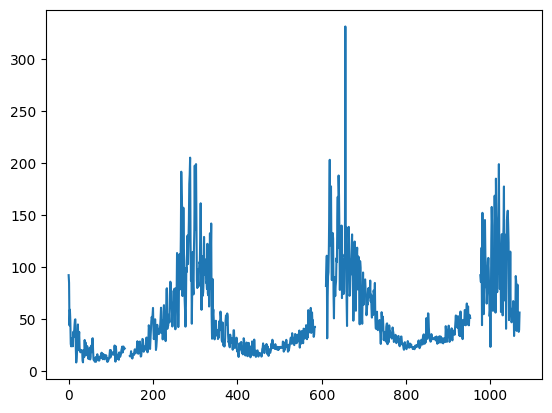

In [ ]:
exp1 = rolling_zscore_outlier_removal(train_df['2'], window=15, z_threshold=2)
exp1_rolled = exp1.fillna(exp1.rolling(15, min_periods=5, center=True).mean())
exp1_rolled.plot()

In [ ]:
def divide_series_into_chunks(series):
    is_nan = series.isna()
    chunks = []
    start_idx = None

    for i, val in enumerate(is_nan):
        if not val and start_idx is None:
            start_idx = i  # Start a new chunk
        elif val and start_idx is not None:
            chunks.append(series[start_idx:i])  # Append the chunk
            start_idx = None

    # Add the last chunk if the series ends without NaNs
    if start_idx is not None:
        chunks.append(series[start_idx:])

    return chunks

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS  

def fill_nans_with_arima(series, sp=12):
    # Get the chunks of non-NaN data
    chunks = divide_series_into_chunks(series)
    filled_series = series.copy()

    for i in range(len(chunks) - 1):
        current_chunk = chunks[i]
        next_chunk_start = chunks[i + 1].index[0]

        # Ensure datetime types
        last_index = current_chunk.index[-1]
        next_start = next_chunk_start

        # Define training and forecasting horizons
        y_train = current_chunk
        print(y_train)
        
        fh = np.arange(last_index+1, next_start)

        # Fit ARIMA and predict the gap
        forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=6)
        forecaster.fit(y_train)
        y_pred = forecaster.predict(fh)

        # Fill the gap in the series
        filled_series.values[last_index+1:next_start] = y_pred

    return filled_series


<Axes: >

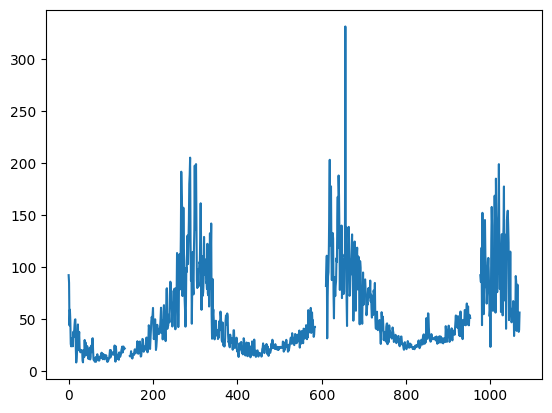

In [ ]:
exp1_rolled.plot()

0      91.982979
1      84.649269
2      43.675636
3      58.792217
4      48.348401
         ...    
129    21.722765
130    23.398181
131    20.439871
132    21.170871
133    21.487891
Name: 2, Length: 134, dtype: float64
145    14.244884
146    14.599381
147    14.817263
148    18.858382
149    12.947662
         ...    
580    39.183792
581    32.666667
582    34.511018
583    42.237202
584    42.237202
Name: 2, Length: 440, dtype: float64
610     81.558208
611     95.285606
612    110.653627
613     31.269231
614     70.248632
          ...    
948     48.251758
949     43.769608
950     53.836291
951     53.247737
952     50.945517
Name: 2, Length: 343, dtype: float64


<Axes: >

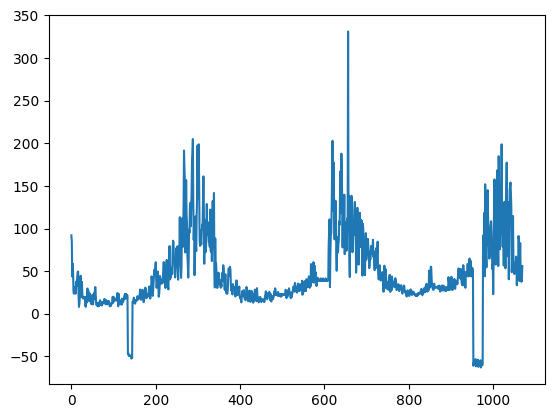

In [ ]:
exp1_filled = fill_nans_with_arima(exp1_rolled)
exp1_filled.plot()

In [ ]:
def fill_missing_with_same_day_values(df, date_col, value_col, direction="both"):
    """
    Fills missing values in a time series by using values from the same day in the next or previous year.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the time series.
        date_col (str): Column name representing the date.
        value_col (str): Column name representing the values with potential missing data.
        direction (str): Direction to search for values ("next", "previous", or "both"). Default is "both".
    
    Returns:
        pd.DataFrame: The dataframe with missing values filled.
    """
    # Ensure the date column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])

    # Create an index for fast lookup
    df.set_index(date_col, inplace=True)

    # Fill missing values
    for idx in df[df[value_col].isna()].index:
        year = idx.year
        day_of_year = idx.timetuple().tm_yday

        # Look for the value in the next year
        next_year_date = pd.Timestamp(year + 1, 1, 1) + pd.Timedelta(days=day_of_year - 1)
        previous_year_date = pd.Timestamp(year - 1, 1, 1) + pd.Timedelta(days=day_of_year - 1)

        value_to_fill = None
        if direction in ["next", "both"] and next_year_date in df.index:
            value_to_fill = df.at[next_year_date, value_col]
        
        if direction in ["previous", "both"] and previous_year_date in df.index and pd.isna(value_to_fill):
            value_to_fill = df.at[previous_year_date, value_col]

        # Assign the value if found
        if not pd.isna(value_to_fill):
            df.at[idx, value_col] = value_to_fill

    # Reset the index
    df.reset_index(inplace=True)

    return df

<Axes: >

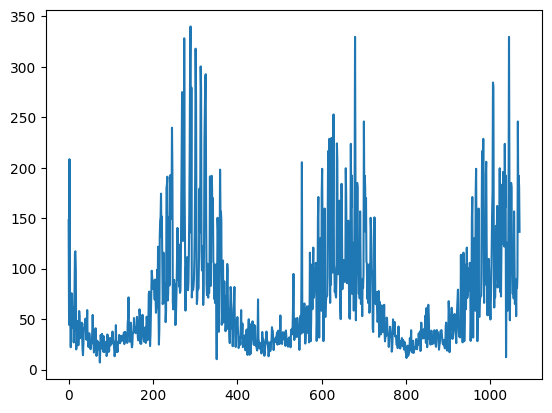

In [ ]:
train_df_filled = fill_missing_with_same_day_values(train_df, "full_date", "1")
train_df_filled['1'].plot()

# full pipeline

In [ ]:
# Step 1: Clean all sensors
def clean_sensors(dataframe, sensors_list, window=15, z_threshold=3):
    cleaned_data = dataframe.copy()
    for sensor in sensors_list:
        cleaned_data[sensor] = rolling_zscore_outlier_removal(dataframe[sensor], window=window, z_threshold=z_threshold)
    return cleaned_data

# Step 2: Apply sensor cluster transformer
def transform_clusters(cleaned_df, clusters):
    transformer = SensorClusterTransformer(clusters=clusters)
    return transformer.transform(cleaned_df)

# Step 3: Fill missing values for all columns in cluster means
def fill_missing_for_all_columns(cluster_means_df, date_col, direction="both"):
    filled_df = cluster_means_df.copy()
    for column in cluster_means_df.columns:
        if column != date_col:
            filled_df = fill_missing_with_same_day_values(
                filled_df, date_col=date_col, value_col=column, direction=direction
            )
    return filled_df

def process_time_series(dataframe, sensors_list, clusters, date_col, window=15, z_threshold=3, direction="both"):
    # Step 1: Clean all sensors
    cleaned_df = clean_sensors(dataframe, sensors_list, window=window, z_threshold=z_threshold)
    
    # Step 2: Calculate cluster means
    cluster_means_df = transform_clusters(cleaned_df, clusters)
    
    # Step 3: Fill missing values
    cluster_means_df_filled = fill_missing_for_all_columns(cluster_means_df, date_col=date_col, direction=direction)
    
    return cluster_means_df_filled

processed_df = process_time_series(
    dataframe=train_df,
    sensors_list=sensors_list,
    clusters=clusters_0,
    date_col="full_date",
    window=60,
    z_threshold=3,
    direction="both"
)

In [ ]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   full_date  1070 non-null   datetime64[ns]
 1   0          1068 non-null   float64       
 2   1          1070 non-null   float64       
 3   2          1069 non-null   float64       
 4   3          1070 non-null   float64       
 5   4          1070 non-null   float64       
 6   5          1070 non-null   float64       
 7   6          1070 non-null   float64       
 8   7          1070 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 75.4 KB


In [ ]:
processed_df[0] = processed_df[0].fillna(processed_df[0].rolling(10, min_periods=5, center=True).mean())
processed_df[2] = processed_df[2].fillna(processed_df[2].rolling(10, min_periods=5, center=True).mean())

In [138]:
def ts_cols_to_long(processed_df, date_col="full_date"):
    long_df = pd.melt(processed_df, id_vars=[date_col], var_name="ID", value_name="value")
    long_df.rename(columns={date_col: "date"}, inplace=True)
    return long_df

In [ ]:
long_df = ts_cols_to_long(processed_df)

In [132]:
# long_df.to_csv(path_to_data+"clusters_data/exp0_train.csv")
# long_df.to_csv(path_to_data+"clusters_data/exp1_train.csv")

add clustered test data 

In [182]:
oot_df = pd.read_csv(path_to_data+"raw_oot.csv")
oot_clust_df = transform_clusters(oot_df, clusters_0)

oot_lonf_df = ts_cols_to_long(oot_clust_df)
# oot_lonf_df.to_csv(path_to_data+"clusters_data/exp0_oot.csv")

In [183]:
pd.concat([processed_df, oot_clust_df]).to_csv(path_to_data+"clusters0_df.csv")

In [163]:
oot_clust_df.to_csv()

,full_date,0,1,2,3,4,5,6,7
0,2020-03-01,111.747030,152.588178,196.137187,61.265649,76.975460,71.410303,67.097544,46.113576
1,2020-03-02,82.020964,110.486055,152.995871,24.920594,31.919838,40.330648,39.212153,22.820844
2,2020-03-03,33.649860,35.094170,44.397356,27.532835,32.533745,32.562538,38.631066,37.504533
3,2020-03-04,47.822443,46.916921,64.765320,42.791704,55.044224,54.611249,48.924843,59.851417
4,2020-03-05,63.182833,79.554507,119.589136,48.827401,52.895477,60.012787,49.054143,47.876804
...,...,...,...,...,...,...,...,...,...
216,2020-10-03,37.480000,37.090000,74.400000,25.850000,40.190000,32.140000,30.945000,27.440000
217,2020-10-04,32.100000,NaN,103.820000,17.520000,26.680000,30.660000,24.565000,25.675000
218,2020-10-05,32.510000,29.550000,75.030000,16.530000,25.935000,27.890000,17.750000,22.300000
219,2020-10-06,21.440000,28.950000,35.300000,13.220000,23.473333,22.920000,17.600000,24.360000


In [150]:
new_df = df[['full_date', 'Grand Total']].rename(columns={"Grand Total": "pm"})
new_df.to_csv(path_to_data+"total_data.csv")

In [151]:
new_df

,full_date,pm
0,2017-03-22,91.982979
1,2017-03-23,84.649269
2,2017-03-24,126.039535
3,2017-03-25,63.183913
4,2017-03-26,38.572597
...,...,...
1286,2020-10-03,41.795789
1287,2020-10-04,32.194444
1288,2020-10-05,30.645000
1289,2020-10-06,24.271667
